# Convolutional Neural Network/CNN

These notes are from Harrisons Tutorial linked below:

https://pythonprogramming.net/convnet-model-deep-learning-neural-network-pytorch/

Data - Deep Learning and Neural Networks with Python and Pytorch

https://youtu.be/i2yPxY2rOzs

pip install opencv-python numpy tqdm matplotlib
images are from "cats vs dogs microsoft dataset"

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False # set to true to recreate data

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        # do something like print(np.eye(2)[1]), just makes one_hot 
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

ModuleNotFoundError: No module named 'cv2'

__DogsVSCats__
    IMG_SIZE : normalize all of the images by reshaping them to all be the same size
    CATS = "PetImages/Cat" : directory variable
    DOGS = "PetImages/Dog" : directory variable
    TESTING = "PetImages/Testing" : directory variable
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    
__make_training_data()__
We read in the data, convert to grayscale, resize the image to whatever we chose, and then append the image data along with the associated class in number form to our training_data.

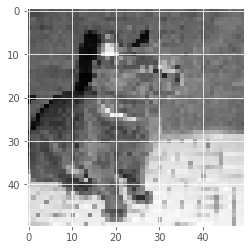

In [68]:
import torch
import matplotlib.pyplot as plt

# Now we can split our training data into X and y, as well as convert it to a tensor:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
plt.imshow(X[0], cmap="gray")

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


Our Nueral Network CNN Net Contains:

__nn.Conv2d 2 layers__
Parameter 1 :: input size
    number of images
Parameter 2 :: output size
    number of convolutions coming back from image
Parameter 3 :: kernal size
    kernel window size. This is the size of the "window" that you take of pixels. A 5 means we're doing a sliding 5x5 window for colvolutions.
    
__nn.Linear 2 layers__
Parameter 1  :: input size
    This is 4*4*50 pixel image (1x784)
Parameter 2 :: output size
    Number of output Classes
    
__Rand Data To Determine Linear Input Size__
To determine the actual shape of the flattened output after the first convolutional layers

__conv func__
x :: image representation as a 1xDIM

    __max_pool2d activation function__
output :: (input data) * weights

    __relu activation function__
output :: run input data through 2x2 window

__feed-forward func__
The initial path of the input will just go through our convs method, which we separated out, again, so we could just run that part, but that's the same code as we'd need to start off this method, but then again we want to also do one regular fully-connected layer, and then another layer will be our output layer.

In [70]:
import torch.optim as optim
import time

#Constants
BATCH_SIZE = 100
EPOCHS = 1

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)


def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))
    
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

test_X.to(device)
test_y.to(device)
    
#train(net)

2494
Running on the CPU


tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

Notes...

In [71]:
import time

MODEL_NAME = f"model-{int(time.time())}"

def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 1

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

train(net)

100%|█████████████████████████████████████████| 225/225 [02:24<00:00,  1.56it/s]


We moved repeated code and started logging some visualization

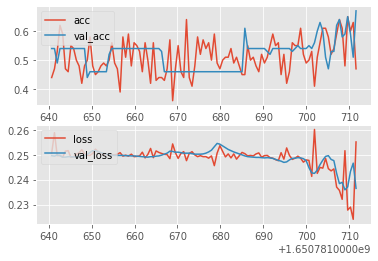

In [72]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1650781640" #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)